In [1]:
# To install the libraries, uncomment the following two lines
#!pip3 install opencv-python
#!pip3 install matplotlib

import cv2 # Open-CV
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
""" Pre-Defined Parameters """
S = 4 # number of cameras in a column
T = 4 # number of cameras in a row
H = 1088 # height of each image
W = 2048 # width of each image
z0 = 100
z1 = 1.63

In [3]:
""" Load Sample Images """
samplesPath = './samples/'
imgArray = np.zeros([S,T,H,W,3])
for fname in os.listdir(samplesPath):
    camera = int(fname[:-4].split('_')[3]) # get the camera number
    s = camera // T
    t = camera % T
    img = cv2.imread(samplesPath+fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # reorder the color channels
    imgArray[s,t,:,:,:] = img[:,:,:]

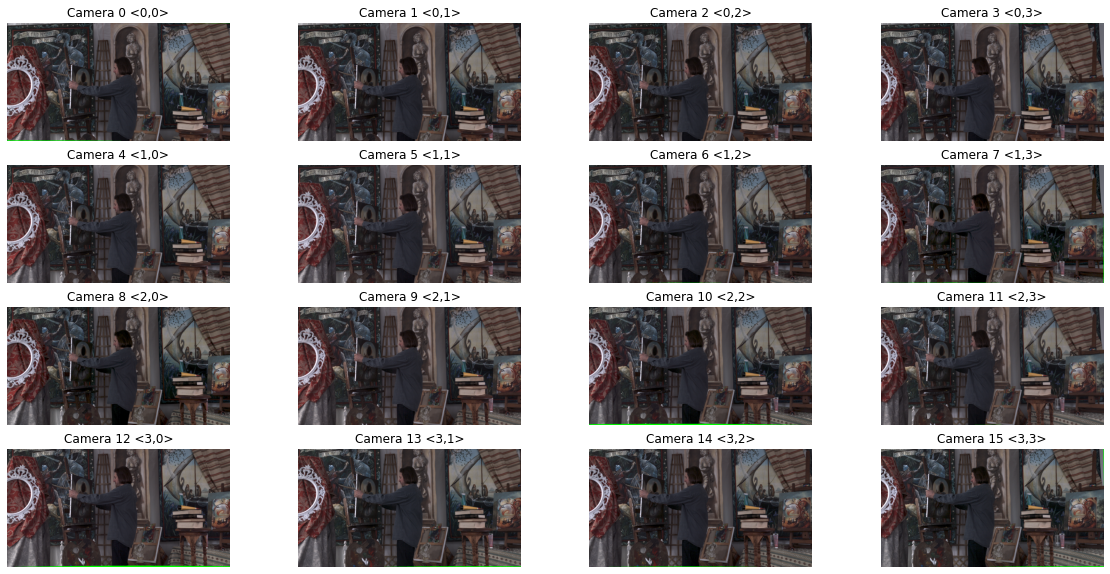

In [41]:
""" Show Images """
plt.figure(figsize=(20,10))
for s in range(S):
    for t in range(T):
        camera = s*T+t
        plt.subplot(S,T,camera+1)
        plt.imshow(imgArray[s,t]/255.)
        plt.axis('off')
        plt.title('Camera '+str(camera)+' <'+str(s)+','+str(t)+'>')

In [5]:
""" Define the Shift Matrix """
## Reference:
##  N. Sabater et al., "Dataset and Pipeline for Multi-view Light-Field Video", 
##  2017 IEEE Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 
##  Honolulu, HI, 2017, pp. 1743-1753.

shiftMat = np.zeros([S,T,2]) # The base Shift Matrix is relative to view (1,1)

shiftMat[:,:,0] = np.array([[100,-0.36,-97.19,-195.55],
                            [98.67,0,-96.18,-197.85],
                            [99.17,0.21,-98.33,-197],
                            [99.08,-1.22,-99.26,-198.36]])

shiftMat[:,:,1] = np.array([[98.28,98.14,98.07,97.35],
                            [-1.73,0,0.74,0.11],
                            [-99.93,-99.11,-101.12,-99.07],
                            [-197.68,-198.14,-198.89,-199.37]])

def changeBaseView(s,t):
    # Compute New Shift Matrix for Camera at (s,t)
    newShiftMat = np.zeros([S,T,2])
    newShiftMat[:,:,0] = shiftMat[:,:,0] - shiftMat[s,t,0];
    newShiftMat[:,:,1] = shiftMat[:,:,1] - shiftMat[s,t,1];
    return newShiftMat

In [26]:
def compute_d(z):
    # compute d(z)
    d = ((1/z)-(1/z0))/((1/z1)-(1/z0)) 
    return d

def translateImg(img, offsetU, offsetV):
    # Use affine transform to shift image
    M = np.float32([[1,0,offsetU],[0,1,offsetV]])
    ret = cv2.warpAffine(img, M, (W,H))
    return ret

def shift_and_sum(imgArray, shiftMat, z):
    d = compute_d(z)
    refocusedImage = np.zeros([H,W,3])
    for s in range(S):
        for t in range(T):
            offsetU = int(-1*d*shiftMat[s,t,0])
            offsetV = int(-1*d*shiftMat[s,t,1])
            refocusedImage = refocusedImage + translateImg(imgArray[s,t], offsetU, offsetV)
    refocusedImage = refocusedImage / (S*T) # averaging
    return refocusedImage


[[ 100.     -0.36  -97.19 -195.55]
 [  98.67    0.    -96.18 -197.85]
 [  99.17    0.21  -98.33 -197.  ]
 [  99.08   -1.22  -99.26 -198.36]]
[[ 9.8280e+01  9.8140e+01  9.8070e+01  9.7350e+01]
 [-1.7300e+00  0.0000e+00  7.4000e-01  1.1000e-01]
 [-9.9930e+01 -9.9110e+01 -1.0112e+02 -9.9070e+01]
 [-1.9768e+02 -1.9814e+02 -1.9889e+02 -1.9937e+02]]


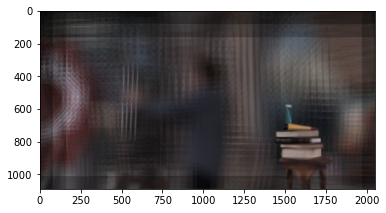

In [33]:
""" Choose a new reference camera, and generate new shift matrix """
newRefCam = (1,1) # the new reference camera
newShiftMat = changeBaseView(newRefCam[0],newRefCam[1])
print(newShiftMat[:,:,0])
print(newShiftMat[:,:,1])

""" Shift and Sum """
z = 2 # depth (in meter)

refocusedImg = shift_and_sum(imgArray, newShiftMat, z)

plt.imshow(refocusedImg/255.)

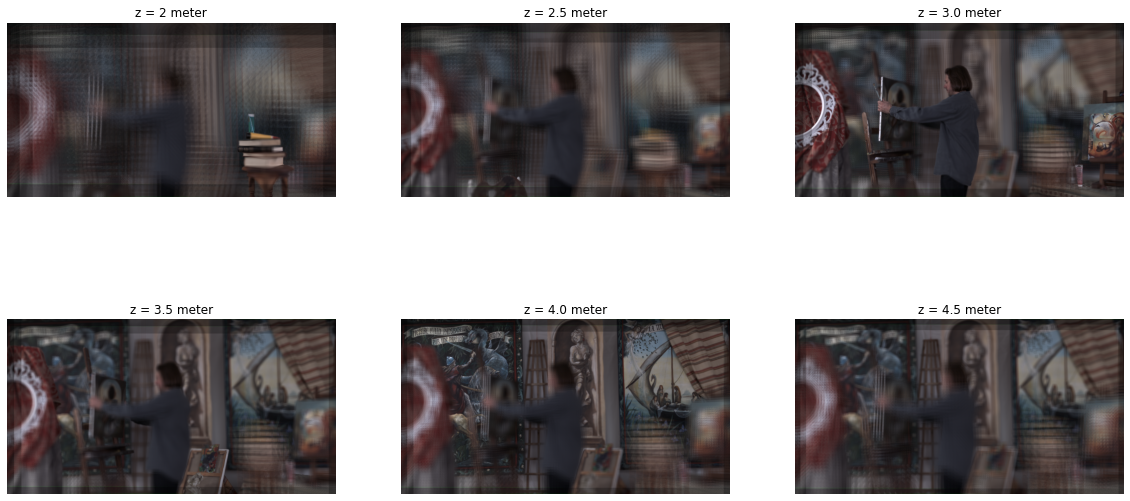

In [37]:
""" Test Different Depth """
z = 2 # start from 2 meter
delta_z = 0.5 # step

newRefCam = (1,1) # the new reference camera
newShiftMat = changeBaseView(newRefCam[0],newRefCam[1])

plt.figure(figsize=(20,10))
for i in range(6):
    refocusedImg = shift_and_sum(imgArray, newShiftMat, z)
    plt.subplot(2,3,i+1)
    plt.imshow(refocusedImg/255.)
    plt.axis('off')
    plt.title('z = '+str(z)+' meter')
    z += delta_z

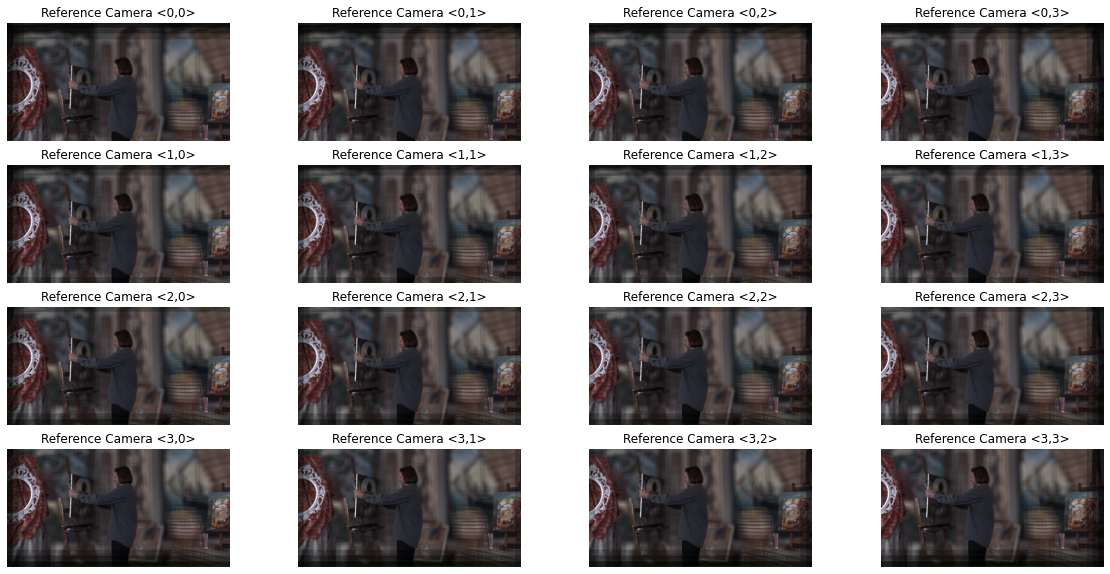

In [40]:
""" Test Different Reference Camera """
z = 3.0
plt.figure(figsize=(20,10))
for s in range(S):
    for t in range(T):
        newRefCam = (s,t) # the new reference camera
        newShiftMat = changeBaseView(newRefCam[0],newRefCam[1])
        refocusedImg = shift_and_sum(imgArray, newShiftMat, z)
        plt.subplot(4,4,s*T+t+1)
        plt.imshow(refocusedImg/255.)
        plt.axis('off')
        plt.title('Reference Camera <'+str(s)+','+str(t)+'>')
